# Self-supervised Learning

In [1]:
import torch
import torchaudio
import torch.nn as nn
import IPython.display as ipd
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

/home/teo/.local/share/virtualenvs/ant5015-2023-5CFwUpZ_/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
!pip install --upgrade gdown
!gdown 15e9E3oZdudErkPKwb0rCAiZXkPxdZkV6
# !wget https://sogang365-my.sharepoint.com/:u:/g/personal/dasaem_jeong_o365_sogang_ac_kr/EdkHWV-qvxBEi-d0Ua73VG4BEp7EZO7HMvrXsWqeJvMJzg?e=GbYylV&download=1

!unzip -q mtat_8000.zip

In [2]:
class MTATDataset:
  def __init__(self, dir_path, split='train', num_max_data=6000, sr=16000):
    self.dir = Path(dir_path)
    self.labels = pd.read_csv(self.dir / "meta.csv", index_col=[0])
    self.sr = sr

    if split=="train":
      sub_dir_ids = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c']
    elif split=='valid':
      sub_dir_ids = ['d']
    else: #test
      sub_dir_ids = ['e', 'f', 'g']

    is_in_set = [True if x[0] in sub_dir_ids else False for x in self.labels['mp3_path'].values.astype('str')]
    self.labels = self.labels.iloc[is_in_set]
    self.labels = self.labels[:num_max_data]
    self.vocab = self.labels.columns.values[1:-1]
    self.label_tensor = self.convert_label_to_tensor()
  
  def convert_label_to_tensor(self):
    return torch.tensor(self.labels.values[:, 1:-1].astype('bool'), dtype=torch.float)

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    info = self.labels.iloc[idx]
    mp3_path = self.dir / info['mp3_path']

    audio, sr = torchaudio.load(mp3_path)
    assert sr == self.sr
    label = self.label_tensor[idx]
    return audio.mean(0), label

data_dir = Path('MTAT_SMALL')
dataset= MTATDataset(data_dir)
dataset[0]

(tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -8.8974e-08,
         -5.8156e-08, -5.6856e-08]),
 tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]))

In [88]:
import random

class OnMemoryDataset(MTATDataset):
  def __init__(self, dir_path, split='train', num_max_data=6000, sr=16000):
    super().__init__(dir_path, split, num_max_data, sr)
    self.loaded_audio = []
    self.load_all_audio()
    self.len_slice = 5

  def load_all_audio(self):
    self.loaded_audio = []
    for idx in tqdm(range(len(self))):
      info = self.labels.iloc[idx]
      mp3_path = self.dir / info['mp3_path']

      audio, sr = torchaudio.load(mp3_path)
      assert sr == self.sr
      self.loaded_audio.append(audio.mean(0))

  def get_random_slice_position(self, len_audio):
    a =  random.randint(0, len_audio - self.len_slice * self.sr - 1)
    b = a + self.len_slice * self.sr
    return a, b
    

  def __getitem__(self, idx):
    audio = self.loaded_audio[idx]
    slice_start, slice_end = self.get_random_slice_position(len(audio))
    anchor = audio[slice_start:slice_end]
    
    slice_start, slice_end = self.get_random_slice_position(len(audio))
    pos = audio[slice_start:slice_end]

    # sample negative songs
    # choose random negative song idx
    random_list = list(range(len(self)))
    del random_list[idx]
    neg_idx = random.choice(random_list)
    neg_audio = self.loaded_audio[neg_idx]
    slice_start, slice_end = self.get_random_slice_position(len(audio))
    neg = neg_audio[slice_start:slice_end]

    return torch.stack([anchor, pos, neg], dim=0)
    return anchor, pos, neg
    # label = self.label_tensor[idx]
    # return audio, label

dataset = OnMemoryDataset(data_dir, num_max_data=5000)
dataset[0]

100%|██████████| 5000/5000 [01:12<00:00, 68.66it/s]


tensor([[ 0.0207,  0.0259,  0.0321,  ..., -0.0089, -0.0042, -0.0032],
        [-0.0045, -0.0025,  0.0005,  ..., -0.0092, -0.0079, -0.0031],
        [ 0.1800, -0.0139, -0.0692,  ...,  0.0303, -0.0148, -0.0740]])

In [37]:
idx = 5
random_list = list(range(len(dataset)))
del random_list[idx]

random.choice(random_list)


13

In [50]:
ipd.display(ipd.Audio(dataset[0][0], rate=16000))
ipd.display(ipd.Audio(dataset[0][1], rate=16000))
ipd.display(ipd.Audio(dataset[0][2], rate=16000))

In [51]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=16)
batch = next(iter(train_loader))

In [53]:
batch.shape

torch.Size([16, 3, 80000])

In [61]:
batch = batch.permute(1,0,2)
print(batch.shape)
flattened_batch = batch.flatten(0, 1)
flattened_batch.shape

torch.Size([16, 3, 80000])


torch.Size([48, 80000])

In [60]:
ipd.display(ipd.Audio(flattened_batch[3], rate=16000))
ipd.display(ipd.Audio(flattened_batch[4], rate=16000))
ipd.display(ipd.Audio(flattened_batch[5], rate=16000))

In [52]:
batch[0].shape, batch[1].shape, batch[2].shape

(torch.Size([3, 80000]), torch.Size([3, 80000]), torch.Size([3, 80000]))

In [87]:
class ConvPool1d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, pool_size):
    super().__init__()
    self.conv_layer = nn.Conv1d(in_channels=in_channels, out_channels=out_channels,
                                kernel_size=kernel_size)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool1d(pool_size)

  def forward(self, x):
    return self.pool(self.relu(self.conv_layer(x)))
  

class SpecConverter(nn.Module):
  def __init__(self, n_fft, hop_length, sr, n_mels):
    super().__init__()
    self.spec = torchaudio.transforms.MelSpectrogram(sample_rate=sr, 
                                                     n_fft=n_fft, 
                                                     hop_length=hop_length, 
                                                     n_mels=n_mels)
    self.db = torchaudio.transforms.AmplitudeToDB()

  def forward(self, x):
    return self.db(self.spec(x)) / 100
  

class AutoTagger(nn.Module):
  def __init__(self, hidden_size=64, output_size=50):
    super().__init__()
    self.spec = SpecConverter(n_fft=1024,
                               hop_length=512,
                               sr=16000,
                               n_mels=64)
    self.layers = nn.Sequential(ConvPool1d(64, hidden_size, 3, 2),
                                ConvPool1d(hidden_size, hidden_size*2, 3, 2),
                                ConvPool1d(hidden_size*2, hidden_size*2, 3, 2),
                                ConvPool1d(hidden_size*2, hidden_size*2, 3, 2),
                                ConvPool1d(hidden_size*2, hidden_size*2, 3, 2),
                                nn.Conv1d(hidden_size*2, hidden_size*2, 1, 1)
                                )
    self.proj = nn.Linear(hidden_size * 4, output_size)

  def forward(self, x):
    spec = self.spec(x)
    cnn_out = self.layers(spec)
    out, _ = torch.max(cnn_out, dim=2)
    return out
  
  def get_proj(self, x):
    spec = self.spec(x) # N x 64 x 911
    cnn_out = self.layers(spec) # N x 256 x 5
    max_pool, _ = torch.max(cnn_out, dim=2) # N x 256

    return self.proj(max_pool).sigmoid()
  

model = AutoTagger()
flattened_batch = batch.flatten(0, 1)
out = model(flattened_batch)
print(out.shape)

out_reshaped = out.reshape(batch.shape[0], batch.shape[1], -1)
out_reshaped.shape

anchor_emb = out_reshaped[:,0]
pos_emb = out_reshaped[:, 1]
neg_emb = out_reshaped[:, 2]

pos_sim = get_cosine_simlarity(anchor_emb, pos_emb)
neg_sim = get_cosine_simlarity(anchor_emb, neg_emb)
margin = 0.4

loss = torch.clamp_min(margin - pos_sim + neg_sim, 0)
loss

torch.Size([48, 128])


tensor([0.4000, 0.3998, 0.3998, 0.3992, 0.3999, 0.4000, 0.3996, 0.3999, 0.4001,
        0.3999, 0.3999, 0.3995, 0.4000, 0.3995, 0.4000, 0.4000],
       grad_fn=<ClampMinBackward0>)

In [91]:
margin = 0.4

model = AutoTagger()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64)

n_epoch = 10
model.train()

loss_record = []

for epoch in tqdm(range(n_epoch)):
  # for batch in tqdm(train_loader):
  for batch in train_loader:
    flattened_batch = batch.flatten(0, 1)
    out = model(flattened_batch.cuda())

    out_reshaped = out.reshape(batch.shape[0], batch.shape[1], -1)

    anchor_emb = out_reshaped[:,0]
    pos_emb = out_reshaped[:, 1]
    neg_emb = out_reshaped[:, 2]

    pos_sim = get_cosine_simlarity(anchor_emb, pos_emb)
    neg_sim = get_cosine_simlarity(anchor_emb, neg_emb)

    loss = torch.clamp_min(margin - pos_sim + neg_sim, 0).mean()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_record.append(loss.item())

100%|██████████| 10/10 [00:31<00:00,  3.18s/it]


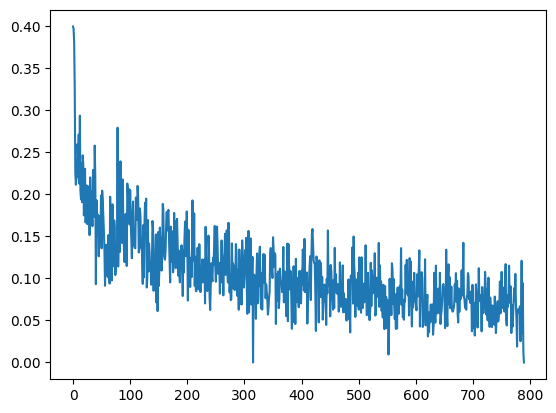

In [92]:
plt.plot(loss_record)

In [ ]:
class Dataset:
  def __init__(self, data_dir, num_slice_len=3, sr=22050):
    self.data_dir = Path(data_dir)
    self.wav_fns = sorted(list(self.data_dir.rglob('*.wav')))
    print(f"Total {len(self.wav_fns)} pieces exist in the directory")

    self.num_slice_len = num_slice_len
    self.sr = sr
    self.genre_names = sorted(list(set([x.parent.name for x in wav_fns])))
    self.gen2idx = {name: i for i, name in enumerate(self.genre_names) }

  def __len__(self):
    return len(self.wav_fns)
    pass

  def __getitem__(self, idx):
    # return audio and label of idx-th data sample
    wav_fn = self.wav_fns[idx]
    y, sr = torchaudio.load(wav_fn)
    assert sr == self.sr
    y = y.mean(dim=0)
    assert y.ndim == 1
    random_slice_position = random.randint(0, len(y)-1-int(sr*self.num_slice_len))
    
    sliced = y[random_slice_position:random_slice_position+int(sr*self.num_slice_len)]
    label = self.gen2idx[wav_fn.parent.name]
    return sliced, label


In [ ]:
class DownStreamModel(nn.Module):
  def __init__(self, model) -> None:
    super().__init__()
    self.backbone = model
    self.prob_layer = nn.Linear(128, 10)
  
  def forward(self, x):
    emb = self.backbone(x)
    out = self.prob_layer(emb)

for param in ds_model.backbone.parameters():
  param.requires_grad = False

In [66]:
anchor_emb.shape, pos_emb.shape, neg_emb.shape

(torch.Size([16, 128]), torch.Size([16, 128]), torch.Size([16, 128]))

In [84]:
def get_cosine_simlarity(tensor_a, tensor_b):
  tensor_a_norm = tensor_a / (tensor_a ** 2).sum(1, keepdim=True) ** 0.5
  tensor_b_norm = tensor_b / (tensor_b ** 2).sum(1, keepdim=True) ** 0.5

  return (tensor_a_norm * tensor_b_norm).sum(dim=1)
   
sims = get_cosine_simlarity(anchor_emb, neg_emb)
sims, sims.shape
# tensor_a= anchor_emb
# tensor_a_norm = tensor_a / (tensor_a ** 2).sum(1, keepdim=True) ** 0.5
# tensor_a_norm.shape

(tensor([0.9999, 0.9998, 0.9997, 0.9988, 0.9998, 0.9999, 0.9998, 0.9999, 0.9999,
         0.9999, 0.9997, 0.9996, 0.9998, 0.9996, 1.0000, 0.9999],
        grad_fn=<SumBackward1>),
 torch.Size([16]))

In [83]:
anchor_emb, pos_emb

(tensor([[-0.0540, -0.0032,  0.0651,  ...,  0.0111,  0.0102,  0.0738],
         [-0.0542, -0.0036,  0.0649,  ...,  0.0114,  0.0100,  0.0742],
         [-0.0537, -0.0043,  0.0648,  ...,  0.0118,  0.0106,  0.0725],
         ...,
         [-0.0541, -0.0032,  0.0647,  ...,  0.0108,  0.0097,  0.0737],
         [-0.0541, -0.0048,  0.0656,  ...,  0.0123,  0.0110,  0.0733],
         [-0.0541, -0.0036,  0.0648,  ...,  0.0112,  0.0102,  0.0738]],
        grad_fn=<SelectBackward0>),
 tensor([[-0.0542, -0.0018,  0.0653,  ...,  0.0105,  0.0101,  0.0742],
         [-0.0530, -0.0033,  0.0638,  ...,  0.0106,  0.0098,  0.0734],
         [-0.0536, -0.0036,  0.0644,  ...,  0.0113,  0.0096,  0.0741],
         ...,
         [-0.0544, -0.0025,  0.0645,  ...,  0.0112,  0.0109,  0.0737],
         [-0.0539, -0.0047,  0.0654,  ...,  0.0120,  0.0112,  0.0730],
         [-0.0543, -0.0042,  0.0665,  ...,  0.0122,  0.0101,  0.0735]],
        grad_fn=<SelectBackward0>))

In [78]:
(tensor_a_norm[0] ** 2).sum()

tensor(1., grad_fn=<SumBackward0>)

In [73]:
(tensor_a ** 2).sum(1, keepdim=False).shape

torch.Size([16])

In [48]:
anchor, pos, neg = batch
anchor_out = model(anchor)
pos_out = model(pos)
neg_out = model(neg)

In [22]:
out[0]

tensor([-0.0331,  0.1006,  0.0051, -0.0476, -0.0038, -0.0059,  0.0825,  0.0800,
         0.0491, -0.0053, -0.0646, -0.0456, -0.0318,  0.0636, -0.0410,  0.0377,
         0.0909,  0.0293,  0.0764, -0.0122,  0.0888,  0.0922, -0.0533, -0.0667,
        -0.0369, -0.0256,  0.0020,  0.0426,  0.0270, -0.0382,  0.0548, -0.0781,
         0.0729, -0.0102, -0.0848, -0.0455, -0.0124, -0.0426,  0.0584,  0.0115,
         0.0364,  0.0647,  0.0546, -0.0417,  0.0311, -0.0394, -0.0418, -0.0127,
        -0.0864,  0.0111,  0.0257,  0.0014, -0.0090,  0.0098,  0.0727, -0.1029,
         0.0867,  0.0242,  0.0218,  0.0493, -0.0698,  0.0048, -0.0711, -0.0531,
         0.0150, -0.0159,  0.0002,  0.0372, -0.0982,  0.0199, -0.0667, -0.0095,
        -0.0193,  0.0400,  0.0628, -0.0987,  0.0726,  0.0078, -0.0816, -0.0952,
         0.0407,  0.0738, -0.0849, -0.0588, -0.0850,  0.0514, -0.0162, -0.0729,
        -0.1208,  0.0331,  0.0123,  0.0189, -0.0746,  0.0607,  0.0655,  0.0410,
         0.0244,  0.0236,  0.0087, -0.05